In [1]:
# Link to dataset: https://archive.ics.uci.edu/dataset/445/absenteeism+at+work
# Install a pip package in the current Jupyter kernel
# Download the csv file
!python3 -m pip install gdown==v4.6.3
!gdown 1ppW5XS4eV0-Eq8-DXbdu-QlyTF3h9yd_

!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install scikit-learn
!python3 -m pip install matplotlib
!python3 -m pip install imbalanced-learn

Downloading...
From: https://drive.google.com/uc?id=1ppW5XS4eV0-Eq8-DXbdu-QlyTF3h9yd_
To: /Users/matthewmartens/Projects/OU-Machine-Learning/Absenteeism_at_work.csv
100%|██████████████████████████████████████| 45.2k/45.2k [00:00<00:00, 54.1MB/s]


In [2]:
#import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import scipy.stats as stats
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE

In [3]:
#Load the data and show the first lines
result = pd.read_csv("Absenteeism_at_work.csv", sep=';')

#Description of the dataset
result.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,...,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,18.017568,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,...,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,11.021247,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,...,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,9.000000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,...,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,...,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


In [4]:
# check duplicate values and delete them
duplicate = result[result.duplicated()]              
print(f'Found {duplicate.shape[0]} duplicates')
result.drop_duplicates(inplace=True)

Found 34 duplicates


In [5]:
# Detect missing values and show heatmap if any exists
df_null = result.isnull()
if(result.isnull() == True).any().any():
    plt.imshow(df_null, origin='lower',extent=[0, 210, 0, 740*2], aspect=0.5)
    print(result[df_null.any(axis=1)].head())
else:
    print("No missing values detected in dataset")



No missing values detected in dataset


In [6]:
# Remove rows where Reason for absence is:
# 7 categories without (CID) patient follow-up (22),
# medical consultation (23), blood donation (24), laboratory examination (25),
# unjustified absence (26), physiotherapy (27), dental consultation (28).
result = result[~result['Reason for absence'].isin([22,23,24,25,26,27,28])]

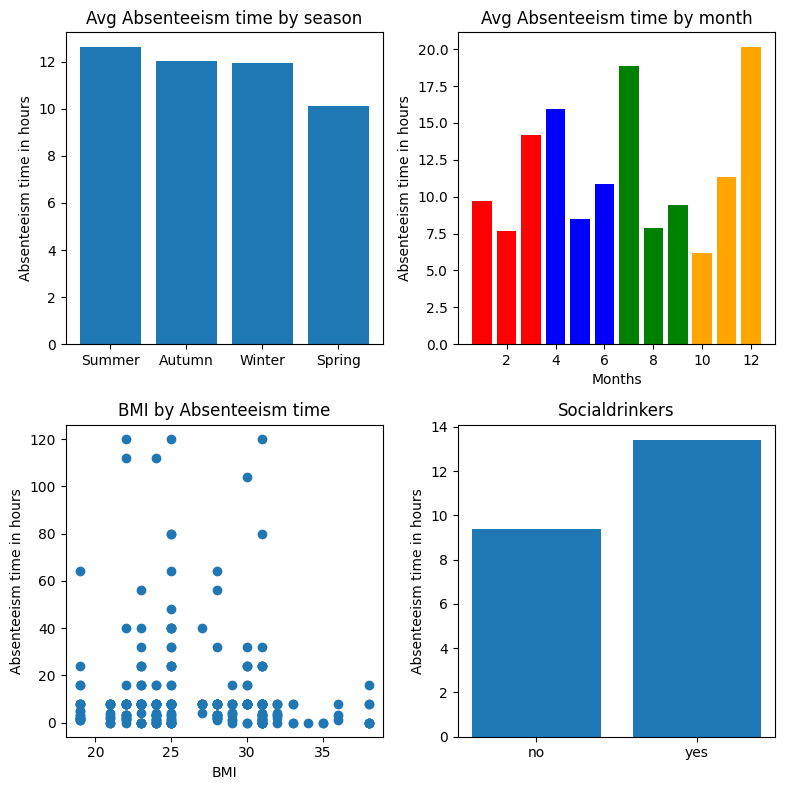

In [7]:
# Display general properties of the dataset
avarage_time_seaons = result.groupby(['Seasons'])['Absenteeism time in hours'].mean()
avarage_time_month = result.groupby(['Month of absence'])['Absenteeism time in hours'].mean()
socialdrinker_duration = result.groupby(['Social drinker'])['Absenteeism time in hours'].mean()
seasons = ("Summer", "Autumn", "Winter", "Spring")
fig, axs = plt.subplots(2,2)
fig.set_size_inches(8,8)
axs[0,0].set_ylabel("Absenteeism time in hours")
axs[0,0].bar(seasons, avarage_time_seaons)
axs[0,0].set_title("Avg Absenteeism time by season")


quarter_colors = ['red', 'blue', 'green', 'orange']
axs[0,1].set_ylabel("Absenteeism time in hours")
axs[0,1].set_xlabel("Months")
axs[0,1].bar(avarage_time_month.index[1:], avarage_time_month[1:], color=[color for color in quarter_colors for _ in range(3)])
axs[0,1].set_title("Avg Absenteeism time by month")

axs[1,0].set_ylabel("Absenteeism time in hours")
axs[1,0].set_xlabel("BMI")
axs[1,0].scatter(result.get('Body mass index'), result.get('Absenteeism time in hours'))
axs[1,0].set_title("BMI by Absenteeism time")

axs[1,1].set_ylabel("Absenteeism time in hours")
axs[1,1].bar(("no", "yes"), socialdrinker_duration)
axs[1,1].set_title("Socialdrinkers")

fig.tight_layout()




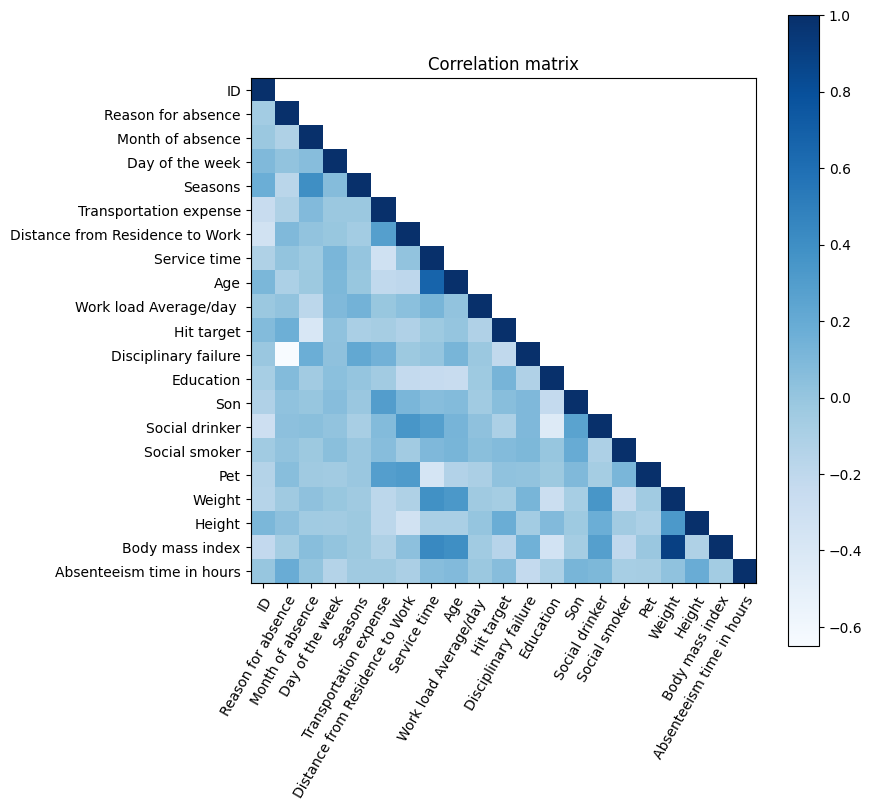

In [8]:
# Display the correlation matrix is a heatmap
# Clear upper traingle in the correlation matrix
corr = result.corr().where(np.tril(np.ones(result.corr().shape), k=0).astype(bool))

fig, ax = plt.subplots()
fig.figure.set_size_inches(9, 9)
im = ax.imshow(corr.values.tolist(), cmap='Blues')
ax.set_title("Correlation matrix")
ax.set_xticks(np.arange(len(result.columns)), labels=np.array(result.columns))
ax.set_yticks(np.arange(len(result.columns)), labels=np.array(result.columns))

plt.setp(ax.get_xticklabels(), rotation=60, ha="right",rotation_mode="anchor")

fig.tight_layout()

_ = plt.colorbar(im)


In [9]:
# Add new feature 
result['hasMoreThan8Hours'] = np.where(result['Absenteeism time in hours']>8, 1, 0)

# Drop height and weight because it is already encoded into BMI
X = pd.get_dummies(result[['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense',
                            'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Disciplinary failure',
                            'Education', 'Son','Social drinker', 'Social smoker', 'Pet', 'Body mass index']])
y = pd.get_dummies(result[['hasMoreThan8Hours']]).hasMoreThan8Hours

print(y.value_counts())
X.head()


hasMoreThan8Hours
0    248
1     57
Name: count, dtype: int64


,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Body mass index
1,0,7,3,1,118,13,18,50,239.554,1,1,1,1,0,0,31
3,7,7,5,1,279,5,14,39,239.554,0,1,2,1,1,0,24
8,19,7,2,1,155,12,14,34,239.554,0,1,2,1,0,0,25
10,1,7,2,1,260,50,11,36,239.554,0,1,4,1,0,0,23
11,1,7,3,1,260,50,11,36,239.554,0,1,4,1,0,0,23


In [10]:
# Using gridsearch and cross validation to get optimal hyperparamters

from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, train_size=0.9)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
gs_results = []

def AppendResult(model):
    # fit the best model with all training data
    model.fit(X_train.values, y_train.values)
    #Append result to array
    gs_results.append(model)
    
cv = 5
    
param_grid ={"C":np.logspace(-4, 4, 10), "solver":['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga']}
log_gscv = GridSearchCV(LogisticRegression(max_iter=9000), param_grid, cv=cv, verbose=1, n_jobs=-1, scoring='recall')
AppendResult(log_gscv)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
SVM_gscv = GridSearchCV(SVC(), param_grid, cv=cv, verbose=1, scoring='recall') 
AppendResult(SVM_gscv)

param_grid = {'n_neighbors': np.arange(1, 20)}
knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, verbose=1, n_jobs=-1, scoring='recall')
AppendResult(knn_gscv)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 30, num = 1)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc_gscv = GridSearchCV(RandomForestClassifier(class_weight="balanced"), param_grid, cv=cv, verbose=1, n_jobs=-1, scoring='recall') 
AppendResult(rfc_gscv)

param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}
lda_gscv = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=cv, verbose=1, n_jobs=-1, scoring='recall') 
AppendResult(lda_gscv)

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nb_gscv = GridSearchCV(GaussianNB(), param_grid, cv=cv, verbose=1, n_jobs=-1, scoring='recall')
AppendResult(nb_gscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [11]:
# best hyperparameters defined
for model in gs_results:
    y_scores = model.best_estimator_.predict(X_test.values)
    print(f'{model.estimator} {model.best_params_}')
    print(f'Accuracy validation set: {accuracy_score(y_test.values, y_scores)}')
    print(f'Precision validation set: {precision_score(y_test.values, y_scores)}')
    print(f'Recall validation set: {recall_score(y_test.values, y_scores)}')
    print(f'ROC: {roc_auc_score(y_test.values, y_scores)}')

LogisticRegression(max_iter=9000) {'C': 2.782559402207126, 'solver': 'newton-cg'}
Accuracy validation set: 0.7419354838709677
Precision validation set: 0.3333333333333333
Recall validation set: 0.3333333333333333
ROC: 0.5866666666666666
SVC() {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy validation set: 0.8064516129032258
Precision validation set: 0.5
Recall validation set: 0.3333333333333333
ROC: 0.6266666666666666
KNeighborsClassifier() {'n_neighbors': 15}
Accuracy validation set: 0.6451612903225806
Precision validation set: 0.2222222222222222
Recall validation set: 0.3333333333333333
ROC: 0.5266666666666666
RandomForestClassifier(class_weight='balanced') {'bootstrap': False, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1}
Accuracy validation set: 0.7741935483870968
Precision validation set: 0.3333333333333333
Recall validation set: 0.16666666666666666
ROC: 0.5433333333333334
LinearDiscriminantAnalysis() {'solver': 'svd'}
Accuracy valid

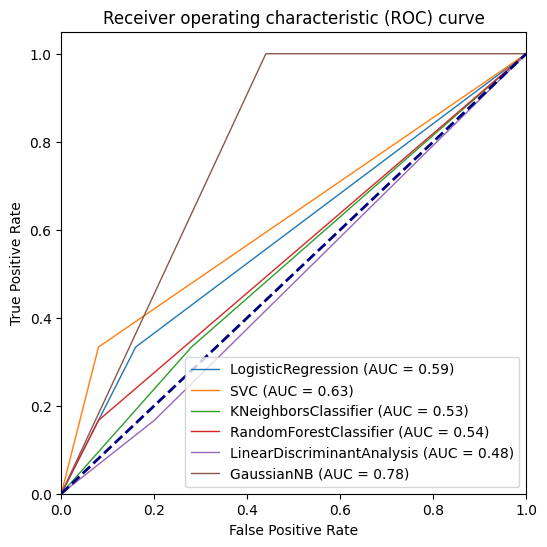

In [12]:
plt.figure(figsize=(6, 6))
# Draw ROC curves of all estimators
for model in gs_results:
    best_model = model.best_estimator_
    y_scrs = best_model.predict(X_test.values)
    fpr, tpr, _ = roc_curve(y_test, y_scrs, )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'{str(best_model).split('(')[0]} (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Gather data to analyse
score_results = []

for model in gs_results:
    for i in range(150):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i, stratify = y, train_size=0.9)

        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        model.best_estimator_.fit(X_train.values, y_train.values)
        y_pred = model.predict(X_test.values)
        name = str(model.best_estimator_).split('(')[0]
        result_tuple = (name, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred))
        score_results.append(result_tuple)


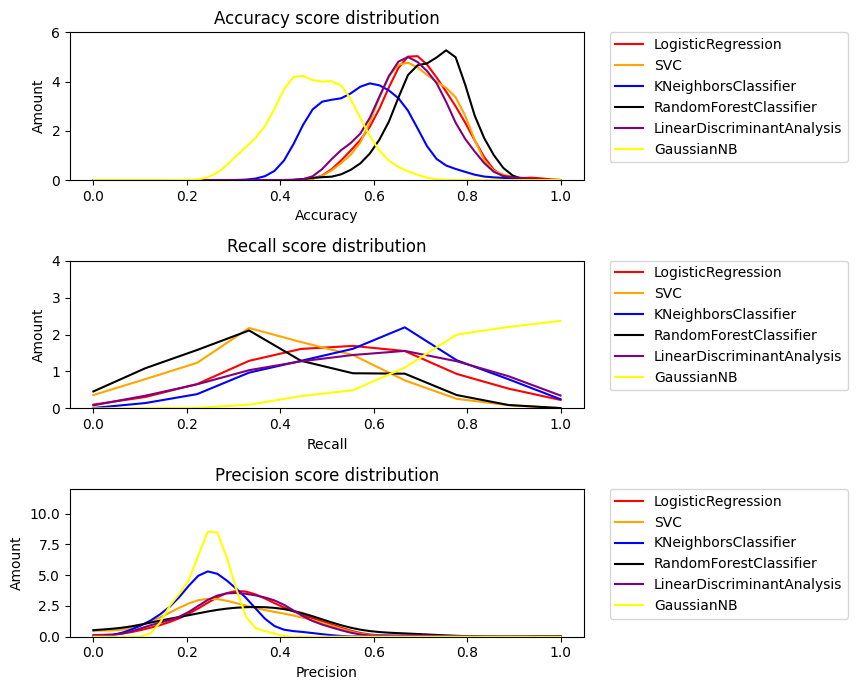

In [14]:
df = pd.DataFrame(score_results, columns=['Algorithm', 'Accuracy', 'Precision', 'Recall'])
colors = {
    'LogisticRegression': 'red',
    'SVC': 'orange',
    'KNeighborsClassifier':'blue',
    'RandomForestClassifier':'black',
    'LinearDiscriminantAnalysis':'purple',
    'GaussianNB':'yellow'
}
fig, ax = plt.subplot_mosaic([['top', 'top','BLANK'],['middle', 'middle', 'BLANK'],['bottom', 'bottom', 'BLANK']], empty_sentinel='BLANK')
fig.set_size_inches(10,7)
for i in df['Algorithm'].unique():
    data = df[df['Algorithm'] == i]['Accuracy']
    density = stats.gaussian_kde(data)
    n, x, chart = plt.hist(data, bins=np.linspace(0, 1, 50), histtype=u'step', density=True)
    chart[0].set_visible(False)
    ax['top'].set_ylim([0,6])
    ax['top'].plot(x, density(x), label=i, color=colors[i])

    data = df[df['Algorithm'] == i]['Recall']
    density = stats.gaussian_kde(data)
    n, x, chart = plt.hist(data, bins=np.linspace(0, 1, 10), histtype=u'step', density=True)
    chart[0].set_visible(False)
    ax['middle'].set_ylim([0,4])
    ax['middle'].plot(x, density(x), label=i, color=colors[i])

    data = df[df['Algorithm'] == i]['Precision']
    density = stats.gaussian_kde(data)
    n, x, chart = plt.hist(data, bins=np.linspace(0, 1, 50), histtype=u'step', density=True)
    chart[0].set_visible(False)
    ax['bottom'].set_ylim([0,12])
    ax['bottom'].plot(x, density(x), label=i, color=colors[i])


ax['top'].set_title('Accuracy score distribution')
ax['top'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax['top'].set_ylabel("Amount")
ax['top'].set_xlabel("Accuracy")
ax['middle'].set_title('Recall score distribution')
ax['middle'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax['middle'].set_ylabel("Amount")
ax['middle'].set_xlabel("Recall")
ax['bottom'].set_title('Precision score distribution')
ax['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax['bottom'].set_ylabel("Amount")
ax['bottom'].set_xlabel("Precision")
fig.tight_layout()
plt.show()

In [15]:
# means
mean_log = df.groupby('Algorithm')[['Recall', 'Accuracy', 'Precision']].mean()
mean_log

,Recall,Accuracy,Precision
Algorithm,,,
GaussianNB,0.833333,0.470753,0.246585
KNeighborsClassifier,0.597778,0.579140,0.255970
LinearDiscriminantAnalysis,0.573333,0.676774,0.316376
LogisticRegression,0.533333,0.691183,0.325797
RandomForestClassifier,0.362222,0.722796,0.319602
SVC,0.385556,0.690753,0.286383


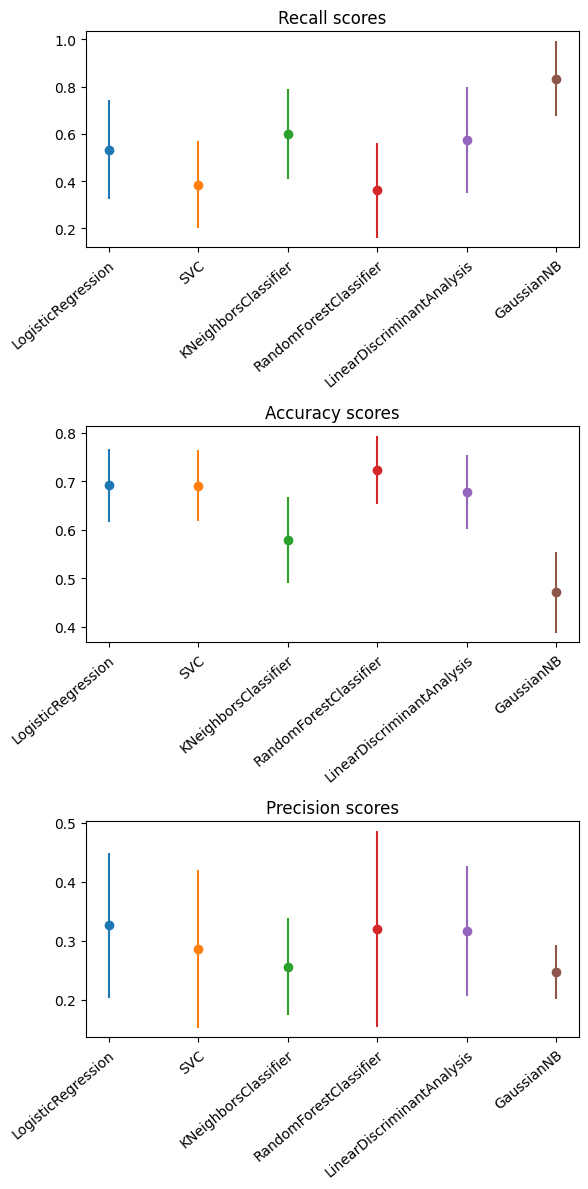

In [16]:
fig, ax = plt.subplot_mosaic([['Recall'], ['Accuracy'], ['Precision']])
fig.set_size_inches(6,12)
for i in df['Algorithm'].unique():
    data = df[df['Algorithm'] == i]['Recall']
    ax['Recall'].errorbar(i, data.mean(), yerr=data.std(), fmt='o')

    data = df[df['Algorithm'] == i]['Accuracy']
    ax['Accuracy'].errorbar(i, data.mean(), yerr=data.std(), fmt='o')

    data = df[df['Algorithm'] == i]['Precision']
    ax['Precision'].errorbar(i, data.mean(), yerr=data.std(), fmt='o')


ax['Recall'].set_title("Recall scores")
ax['Accuracy'].set_title("Accuracy scores")
ax['Precision'].set_title("Precision scores")

plt.setp(ax['Recall'].get_xticklabels(), rotation=40, ha="right",rotation_mode="anchor")
plt.setp(ax['Accuracy'].get_xticklabels(), rotation=40, ha="right",rotation_mode="anchor")
plt.setp(ax['Precision'].get_xticklabels(), rotation=40, ha="right",rotation_mode="anchor")

fig.tight_layout()


In [17]:
from scipy.stats import f_oneway
acc_data = [df for (name, df) in df.groupby('Algorithm')['Accuracy']]
print("Accuracy ANOVA")
print(f_oneway(acc_data[0], acc_data[1], acc_data[2], acc_data[3], acc_data[4], acc_data[5]))

acc_data = [df for (name, df) in df.groupby('Algorithm')['Recall']]
print("Accuracy Recall")
print(f_oneway(acc_data[0], acc_data[1], acc_data[2], acc_data[3], acc_data[4], acc_data[5]))

acc_data = [df for (name, df) in df.groupby('Algorithm')['Precision']]
print("Accuracy Precision")
print(f_oneway(acc_data[0], acc_data[1], acc_data[2], acc_data[3], acc_data[4], acc_data[5]))

Accuracy ANOVA
F_onewayResult(statistic=225.793864855202, pvalue=8.820420925185239e-156)
Accuracy Recall
F_onewayResult(statistic=113.49236166034493, pvalue=6.722459435837931e-93)
Accuracy Precision
F_onewayResult(statistic=13.063581949458722, pvalue=2.713963825903134e-12)


In [18]:
import math
# t-tests
acc_data = [df for (name, df) in df.groupby('Algorithm')['Accuracy']]
rec_data = [df for (name, df) in df.groupby('Algorithm')['Recall']]
pre_data = [df for (name, df) in df.groupby('Algorithm')['Precision']]

algorithms = [name for (name, df) in df.groupby('Algorithm')]
size = len(algorithms)
stats_results = []

for i in range(size):
    for j in range(size):
        if(i > j):
            [acc_t, acc_p] = stats.ttest_ind(acc_data[i], acc_data[j])
            [rec_t, rec_p] = stats.ttest_ind(rec_data[i], rec_data[j])
            [pre_t, pre_p] = stats.ttest_ind(pre_data[i], pre_data[j])
            stats_results.append((algorithms[i], algorithms[j], acc_p, rec_p, pre_p))
stats_df = pd.DataFrame(stats_results, columns=['Algorithm 1', 'Algorithm 2', 'Accuracy pvalue', 'Recall pvalue', 'Precision pvalue'])
print(f"Amount of comparisions {(math.comb(size, 2))} Adjusted critical p-value: ", 0.05/(math.comb(size, 2)))
pd.options.display.float_format = '{:.3g}'.format
stats_df.sort_values('Recall pvalue', ascending=False)

Amount of comparisions 15 Adjusted critical p-value:  0.0033333333333333335


,Algorithm 1,Algorithm 2,Accuracy pvalue,Recall pvalue,Precision pvalue
2,LinearDiscriminantAnalysis,KNeighborsClassifier,3.9e-21,0.311,1.41e-07
14,SVC,RandomForestClassifier,0.000131,0.296,0.0569
5,LogisticRegression,LinearDiscriminantAnalysis,0.0994,0.113,0.483
4,LogisticRegression,KNeighborsClassifier,1.23e-26,0.00567,1.53e-08
13,SVC,LogisticRegression,0.96,3.76e-10,0.00804
9,RandomForestClassifier,LogisticRegression,0.000188,4.7e-12,0.713
12,SVC,LinearDiscriminantAnalysis,0.106,5.63e-14,0.0346
8,RandomForestClassifier,LinearDiscriminantAnalysis,1.09e-07,6.5e-16,0.843
11,SVC,KNeighborsClassifier,7.92e-27,7.26e-20,0.018
7,RandomForestClassifier,KNeighborsClassifier,3.04e-40,7.45e-22,3.32e-05


In [19]:
# Base line models
# Majority
acc_data = [df for (name, df) in df.groupby('Algorithm')['Accuracy']]
majc_prop = 1-np.mean(y)

result = stats.ttest_1samp(acc_data[0], majc_prop, alternative='greater')

print(majc_prop, np.mean(acc_data[0]), result.pvalue)

# Minority
minc_prop = np.mean(y)

result = stats.ttest_1samp(acc_data[0], minc_prop, alternative='greater')

print(minc_prop, np.mean(acc_data[0]), result.pvalue)

0.8131147540983606 0.4707526881720431 1.0
0.18688524590163935 0.4707526881720431 1.0917813048239392e-84
